In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.over_sampling import RandomOverSampler
from sklearn.preprocessing import StandardScaler
import copy
import seaborn as sns
import tensorflow as tf
from sklearn.linear_model import LinearRegression

In [2]:
data_cols=["bike_count","hour","temp","humiditiy","wind","visibility","dew_pt_temp","radiation","rain","snow","functional"]
df = pd.read_csv("SeoulBikeData.csv", encoding='latin1').drop(["Date","Holiday","Seasons"],axis=1)

df.head()


,Rented Bike Count,Hour,Temperature(°C),Humidity(%),Wind speed (m/s),Visibility (10m),Dew point temperature(°C),Solar Radiation (MJ/m2),Rainfall(mm),Snowfall (cm),Functioning Day
0,254,0,-5.2,37,2.2,2000,-17.6,0.0,0.0,0.0,Yes
1,204,1,-5.5,38,0.8,2000,-17.6,0.0,0.0,0.0,Yes
2,173,2,-6.0,39,1.0,2000,-17.7,0.0,0.0,0.0,Yes
3,107,3,-6.2,40,0.9,2000,-17.6,0.0,0.0,0.0,Yes
4,78,4,-6.0,36,2.3,2000,-18.6,0.0,0.0,0.0,Yes


In [3]:
df.columns=data_cols
df['functional']=(df['functional']=="Yes").astype(int)
df=df[df["hour"]==12]
df=df.drop(["hour"],axis=1)

In [4]:
df.head()

,bike_count,temp,humiditiy,wind,visibility,dew_pt_temp,radiation,rain,snow,functional
12,449,1.7,23,1.4,2000,-17.2,1.11,0.0,0.0,1
36,479,4.3,41,1.3,1666,-7.8,1.09,0.0,0.0,1
60,333,5.8,85,1.7,349,3.4,0.43,0.0,0.0,1
84,393,-0.3,38,4.8,1823,-12.9,1.11,0.0,0.0,1
108,321,-2.3,25,0.0,1962,-19.7,0.00,0.0,0.0,1


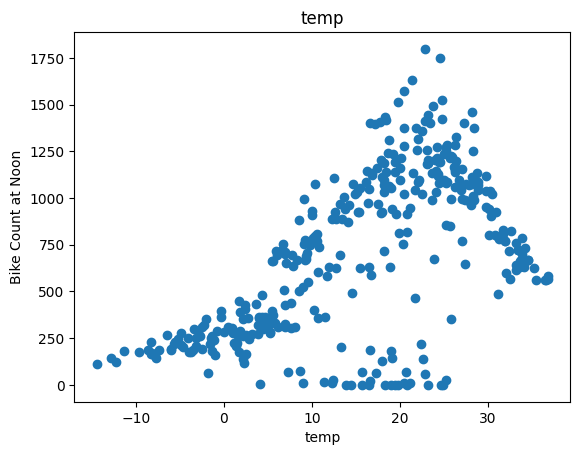

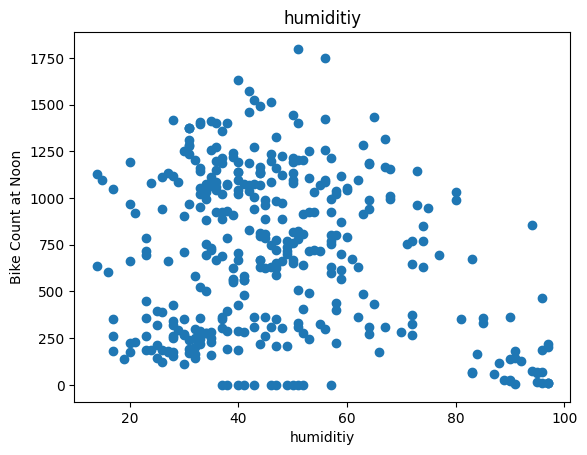

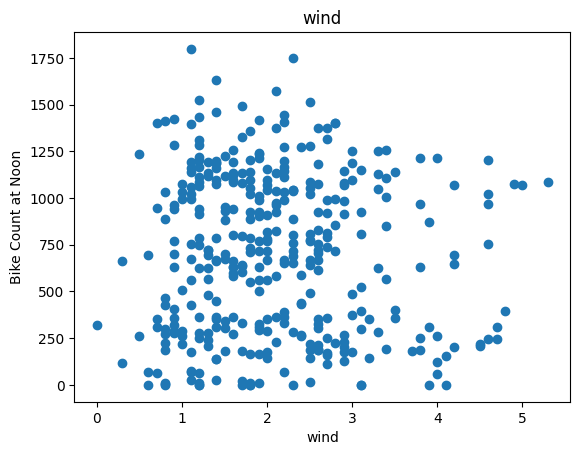

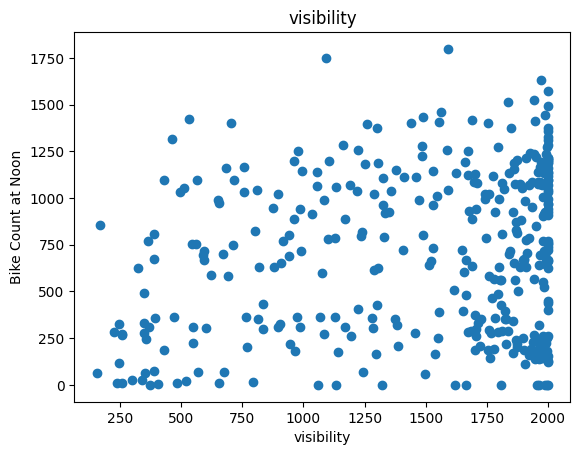

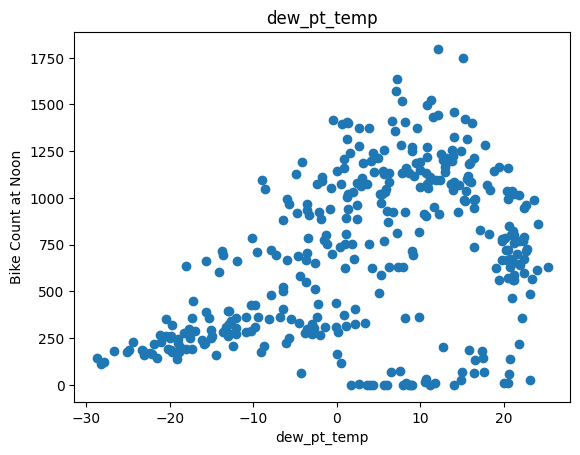

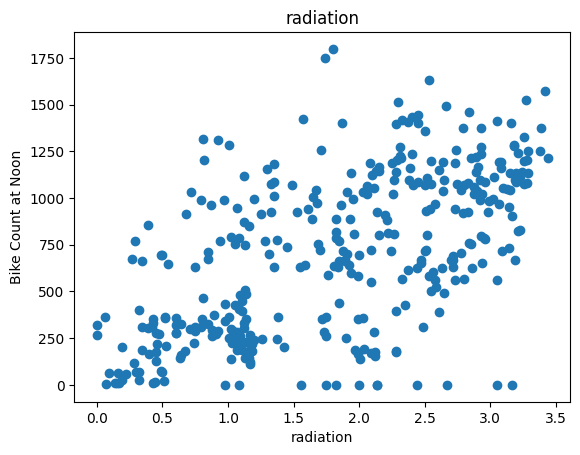

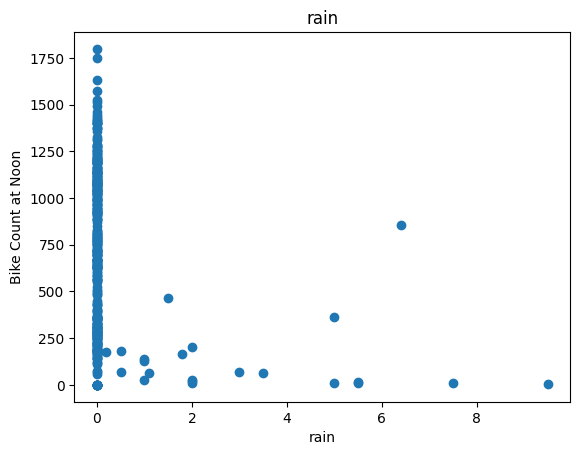

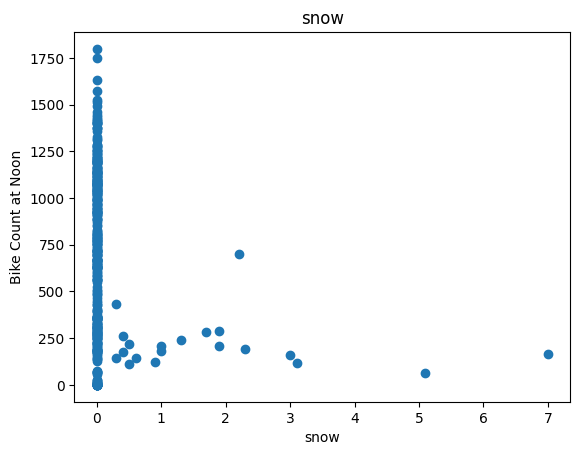

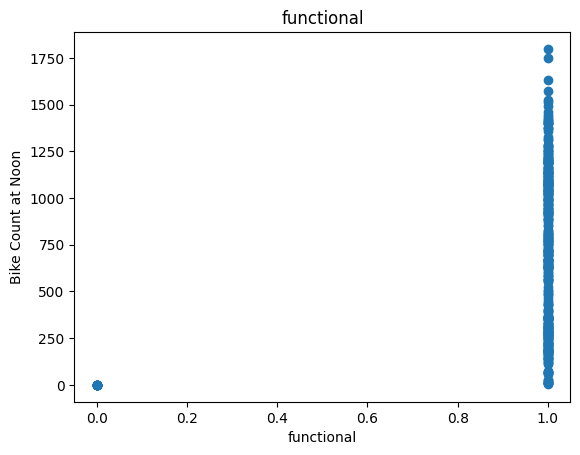

In [5]:
for label in df.columns[1:]:
    plt.scatter(df[label],df['bike_count'])
    plt.title(label)
    plt.ylabel('Bike Count at Noon')
    plt.xlabel(label)
    plt.show()

In [6]:
df=df.drop(['wind','visibility','functional'],axis=1)

In [7]:
df.head()

,bike_count,temp,humiditiy,dew_pt_temp,radiation,rain,snow
12,449,1.7,23,-17.2,1.11,0.0,0.0
36,479,4.3,41,-7.8,1.09,0.0,0.0
60,333,5.8,85,3.4,0.43,0.0,0.0
84,393,-0.3,38,-12.9,1.11,0.0,0.0
108,321,-2.3,25,-19.7,0.00,0.0,0.0


# Train/valid/test Dataset

In [8]:
train,val,test=np.split(df.sample(frac=1),[int(0.6*len(df)),int(0.8*len(df))])

c:\Python312\Lib\site-packages\numpy\core\fromnumeric.py:59: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [9]:
def get_xy(dataframe,y_label,x_labels=None):
    dataframe=copy.deepcopy(dataframe)
    if x_labels is None:
        X=dataframe[[c for c in dataframe.columns if c!=y_label]].values
    else:
        if len(x_labels)==1:
          X=dataframe[x_labels[0]].values.reshape(-1,1)
        else:
          X=dataframe[x_labels].values

    y=dataframe[y_label].values.reshape(-1,1)
    data=np.hstack((X,y))

    return data,X,y

In [10]:
_,X_train_temp,y_train_temp=get_xy(df,'bike_count',x_labels=["temp"])
_,X_val_temp,y_val_temp=get_xy(val,'bike_count',x_labels=["temp"])
_,X_test_temp,y_test_temp=get_xy(test,'bike_count',x_labels=["temp"])

In [11]:
temp_reg=LinearRegression()
temp_reg.fit(X_train_temp,y_train_temp)

LinearRegression()

In [12]:
print(temp_reg.coef_,temp_reg.intercept_)

[[20.84124918]] [377.18970415]


In [13]:
temp_reg.score(X_test_temp,y_test_temp)

0.41530960943685513

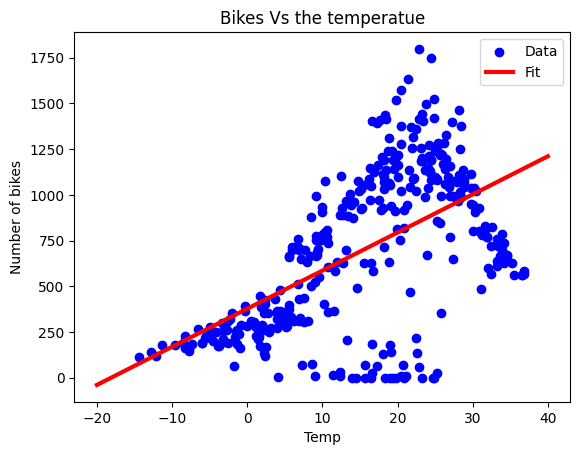

In [14]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_reg.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes Vs the temperatue")
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Multiple Linear Regression

In [98]:
_,X_train,y_train=get_xy(df,'bike_count',x_labels=df.columns[1:])
_,X_val,y_val=get_xy(val,'bike_count',x_labels=df.columns[1:])
_,X_test,y_test=get_xy(test,'bike_count',x_labels=df.columns[1:])

In [99]:
all_reg=LinearRegression()
all_reg.fit(X_train,y_train)

LinearRegression()

In [100]:
all_reg.score(X_test,y_test)

0.4623503926253617

# Regression with Neural Net

In [18]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train_temp.reshape(-1))

c:\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
temp_nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(1)
])

In [20]:
temp_nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss='mean_squared_error')

In [21]:
history=temp_nn_model.fit(
    X_train_temp.reshape(-1),y_train_temp,
    verbose=0,
    epochs=1000,
    validation_data=(X_val_temp,y_val_temp)
)

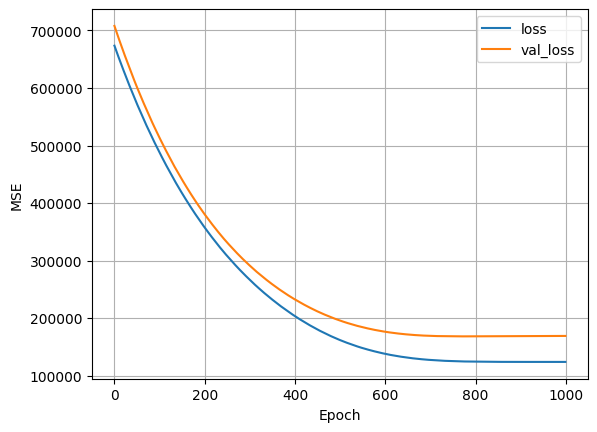

In [22]:
def plot_loss(history):
    plt.plot(history.history['loss'],label='loss')
    plt.plot(history.history['val_loss'],label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('MSE')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


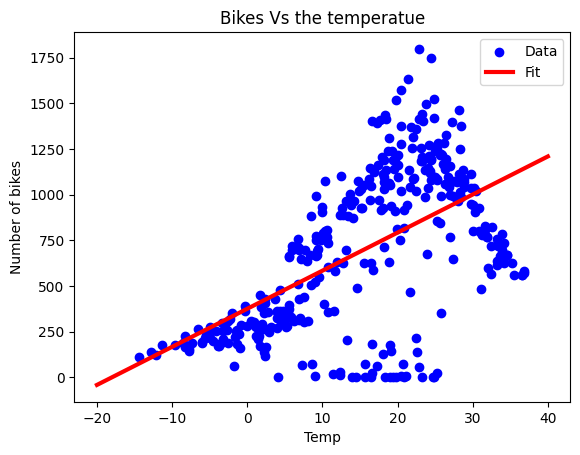

In [23]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,temp_nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes Vs the temperatue")
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

# Neuaral Networks

In [24]:
temp_normalizer=tf.keras.layers.Normalization(input_shape=(1,),axis=None)
temp_normalizer.adapt(X_train.reshape(-1))
nn_model=tf.keras.Sequential([
    temp_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
     tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(1),
])

In [25]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [26]:
history=nn_model.fit(
    X_train_temp,y_train_temp,
    validation_data=[X_val_temp,y_val_temp],
    verbose=0,epochs=100
)

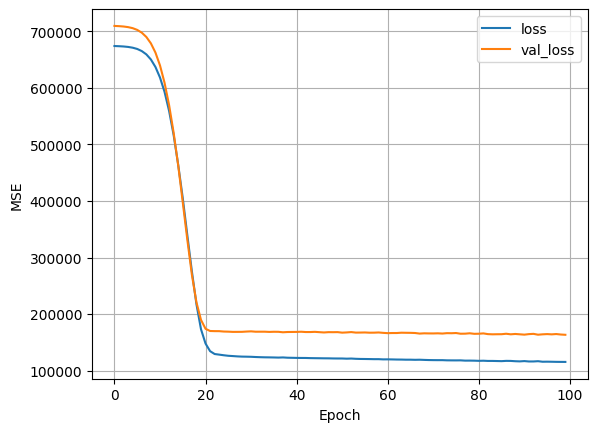

In [27]:
plot_loss(history)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 


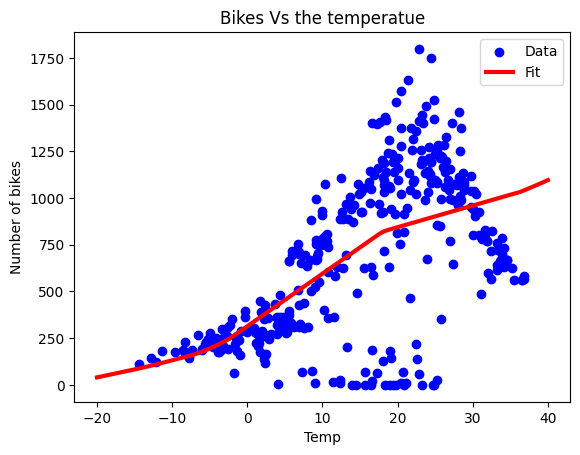

In [28]:
plt.scatter(X_train_temp,y_train_temp,label='Data',color='blue')
x=tf.linspace(-20,40,100)
plt.plot(x,nn_model.predict(np.array(x).reshape(-1,1)),label="Fit",color="red",linewidth=3)
plt.legend()
plt.title("Bikes Vs the temperatue")
plt.ylabel('Number of bikes')
plt.xlabel('Temp')
plt.show()

In [104]:
_,X_train_all,y_train_all=get_xy(df,'bike_count',x_labels=df.columns[1:])
_,X_val_all,y_val_all=get_xy(val,'bike_count',x_labels=df.columns[1:])
_,X_test_all,y_test_all=get_xy(test,'bike_count',x_labels=df.columns[1:])

In [105]:
all_normalizer=tf.keras.layers.Normalization(input_shape=(6,),axis=-1)
all_normalizer.adapt(X_train_all)


c:\Python312\Lib\site-packages\keras\src\layers\preprocessing\tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [106]:
nn_model=tf.keras.Sequential([
    all_normalizer,
    tf.keras.layers.Dense(32,activation='relu'),
     tf.keras.layers.Dense(32,activation='relu'),
      tf.keras.layers.Dense(1),
])

In [107]:
nn_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),loss='mean_squared_error')

In [108]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 365 entries, 12 to 8748
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   bike_count   365 non-null    int64  
 1   temp         365 non-null    float64
 2   humiditiy    365 non-null    int64  
 3   dew_pt_temp  365 non-null    float64
 4   radiation    365 non-null    float64
 5   rain         365 non-null    float64
 6   snow         365 non-null    float64
dtypes: float64(5), int64(2)
memory usage: 22.8 KB


In [109]:
print("X_train shape:", X_train_all.shape)  # Should be (num_samples, 6)
print("y_train shape:", y_train_all.shape)    # Should be (num_samples,)
print("X_val shape:", X_val_all.shape)        # Should be (num_samples, 6)
print("y_val shape:", y_val_all.shape)        # Should be (num_samples,)
print(type(X_train_all))
X_train_all=X_train_all.astype('int32')

X_train shape: (365, 6)
y_train shape: (365, 1)
X_val shape: (73, 6)
y_val shape: (73, 1)
<class 'numpy.ndarray'>


In [110]:
X_train_all = X_train_all.astype('int32')
y_train_all = y_train_all.astype('int32')
X_val_all = X_val_all.astype('int32')
y_val_all = y_val_all.astype('int32')


In [111]:
print("NaN in X_train_all:", np.any(np.isnan(X_train_all)))
print("Infinite in X_train_all:", np.any(np.isinf(X_train_all)))

print("NaN in y_train_all:", np.any(np.isnan(y_train_all)))
print("Infinite in y_train_all:", np.any(np.isinf(y_train_all)))


NaN in X_train_all: False
Infinite in X_train_all: False
NaN in y_train_all: False
Infinite in y_train_all: False


In [112]:
y_train_all = y_train_all.reshape(-1)  # Flatten to 1D if necessary


In [114]:
history = nn_model.fit(
    X_train_all, y_train_all,
    validation_data=[X_val_all, y_val_all],  # Ensure validation data is also correctly shaped
    verbose=0, epochs=100
)

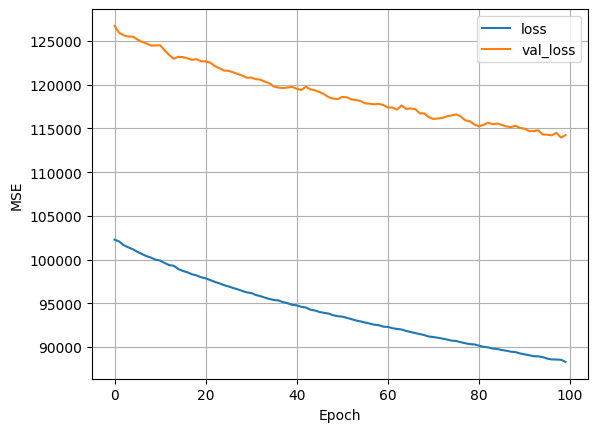

In [115]:
plot_loss(history)

In [116]:
# Calculate the MSE of the Linear regression and Neural Networks
y_pred_lr=all_reg.predict(X_test_all)
y_pred_nn=nn_model.predict(X_test_all)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


In [117]:
def MSE(y_pred,y_real):
    return (np.square(y_pred-y_real)).mean()

In [118]:
MSE(y_pred_lr,y_test_all)

99199.75340373682

In [119]:
MSE(y_pred_nn,y_test_all)

83715.53054929248

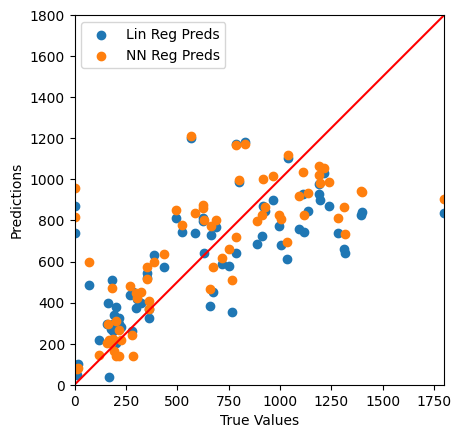

In [122]:
ax=plt.axes(aspect="equal")
plt.scatter(y_test_all,y_pred_lr,label="Lin Reg Preds")
plt.scatter(y_test_all,y_pred_nn,label="NN Reg Preds")
plt.xlabel("True Values")
plt.ylabel("Predictions")
lims=[0,1800]
plt.xlim(lims)
plt.ylim(lims)
plt.legend()
_ =plt.plot(lims,lims,c="red")